In [1]:
import sys
from pathlib import Path

# Add the src directory to Python path
repo_root = Path.cwd().parent  # Go up one level from notebooks/ to repo root
src_path = repo_root / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Now import the class
from models.basic import TwoStageCapacityAndProcurementPlanning

print(f"✓ Successfully imported TwoStageCapacityAndProcurementPlanning")
print(f"  Repository root: {repo_root}")
print(f"  Source path: {src_path}")

✓ Successfully imported TwoStageCapacityAndProcurementPlanning
  Repository root: c:\Users\siatr\VS Code Workspace\steel-industry-stochastic-optimization
  Source path: c:\Users\siatr\VS Code Workspace\steel-industry-stochastic-optimization\src


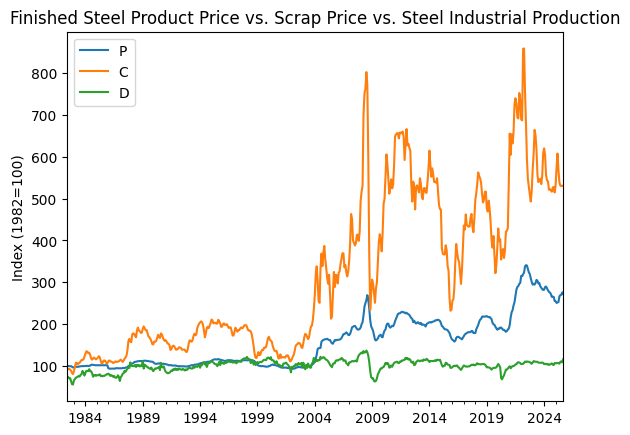

✓ Data loaded successfully: (520, 3) observations
Date range: 1982-06-01 00:00:00 to 2025-09-01 00:00:00

Data summary:
                P           C           D
count  520.000000  520.000000  520.000000
mean   156.732848  315.815242  100.391806
std     63.143044  190.527190   13.437843
min     92.500000   80.000000   55.160000
25%    101.200000  152.125000   93.878675
50%    116.300000  224.600000  102.977650
75%    198.275000  496.925000  109.398475
max    340.699000  859.242000  136.372100


In [ ]:
# Load data
data = TwoStageCapacityAndProcurementPlanning.load_data_from_fredapi(
    'add_your_fred_api_key_here',  # Replace with your actual FRED API key
    steel_demand_identifier='IPG3311A2S', 
    scrap_price_identifier='WPU1012', 
    steel_price_identifier='WPU101704',
    plot_data=True)

print(f"✓ Data loaded successfully: {data.shape} observations")
print(f"Date range: {data.index.min()} to {data.index.max()}")
print("\nData summary:")
print(data.describe())

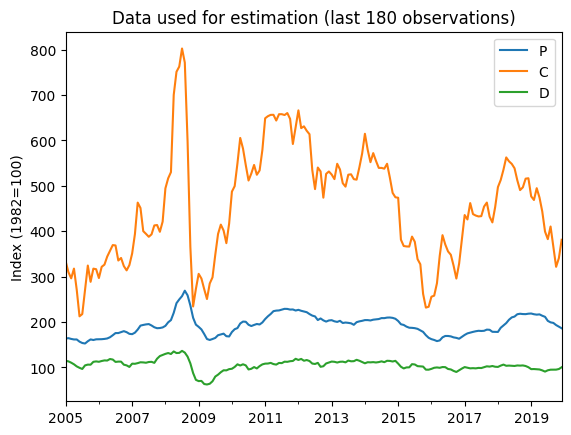

✓ Data subset created: (180, 3) observations
Subset date range: 2005-01-01 00:00:00 to 2019-12-01 00:00:00


In [3]:
data_subset = TwoStageCapacityAndProcurementPlanning.get_n_observations(
    data,
    n=180,
    p=2,
    last_observation='2019-12-01',
    plot_data=True)

print(f"✓ Data subset created: {data_subset.shape} observations")
print(f"Subset date range: {data_subset.index.min()} to {data_subset.index.max()}")

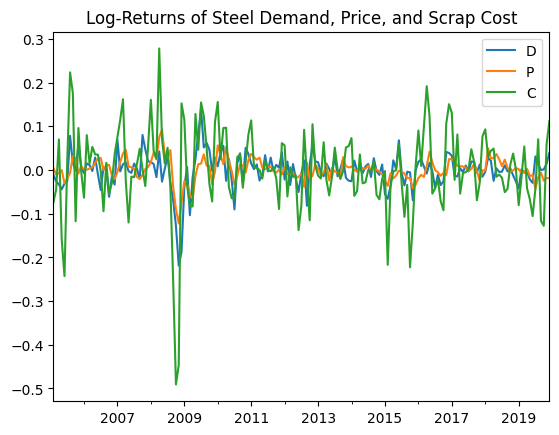

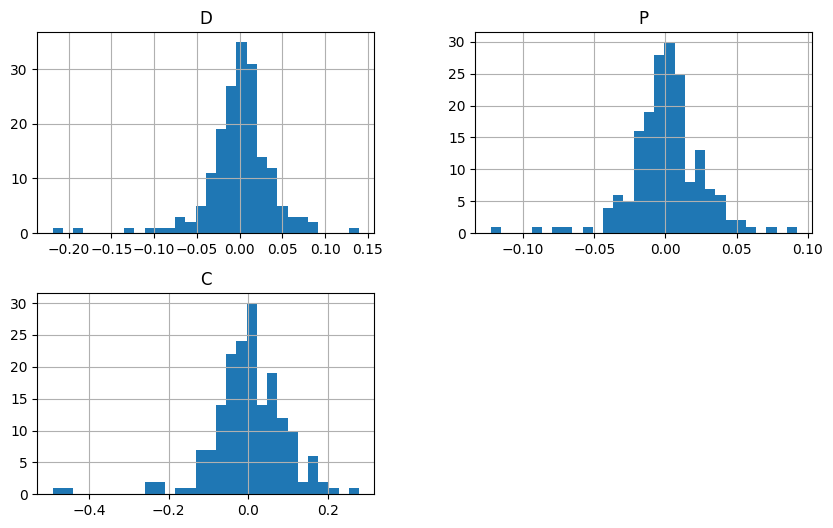

Log-Returns Statistics:
                 D         P         C
mean     -0.000739  0.000726  0.000742
std       0.040092  0.025572  0.096014
skew     -1.423401 -0.580622 -1.242416
kurtosis  7.631809  4.303891  5.943390
✓ Log returns computed: (179, 3) observations
Missing values: 0


In [4]:
Δlog = TwoStageCapacityAndProcurementPlanning.log_returns(
    data_subset,
    plot_data=True,
    print_stats=True)

print(f"✓ Log returns computed: {Δlog.shape} observations")
print(f"Missing values: {Δlog.isnull().sum().sum()}")

VAR MODEL ESTIMATION
• Computing log returns from provided data

----------------------------------------
DATA QUALITY CHECKS
----------------------------------------
⚠ D: 1 extreme values (|Δlog| > 20.0%)
   Extreme dates: [Timestamp('2008-11-01 00:00:00')]
✓ P: No extreme values detected
⚠ C: 8 extreme values (|Δlog| > 20.0%)
   Extreme dates: [Timestamp('2005-06-01 00:00:00'), Timestamp('2005-08-01 00:00:00'), Timestamp('2008-04-01 00:00:00')]...
✓ No suspicious correlations detected

• Using specified lag order: p=2

• Fitting VAR(2) model...
✓ VAR(2) model fitted successfully
  Effective sample size: 177
  AIC: -20.41
  BIC: -20.04
  Log-likelihood: 1074.06

MODEL VALIDATION TESTS

----------------------------------------
RESIDUAL CORRELATION ANALYSIS
----------------------------------------
Residual Correlation Matrix:
          D         P         C
D  1.000000  0.172483  0.463215
P  0.172483  1.000000  0.488007
C  0.463215  0.488007  1.000000

Economic Interpretation:
• Demand-

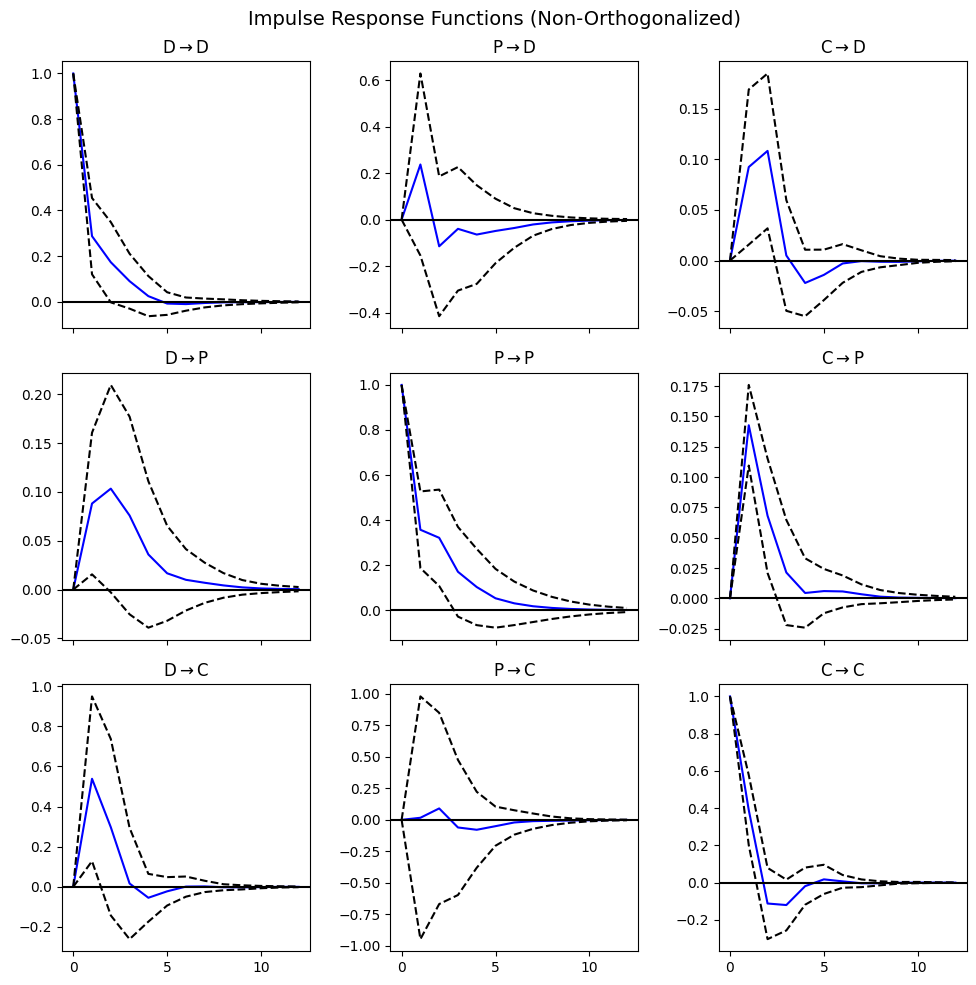

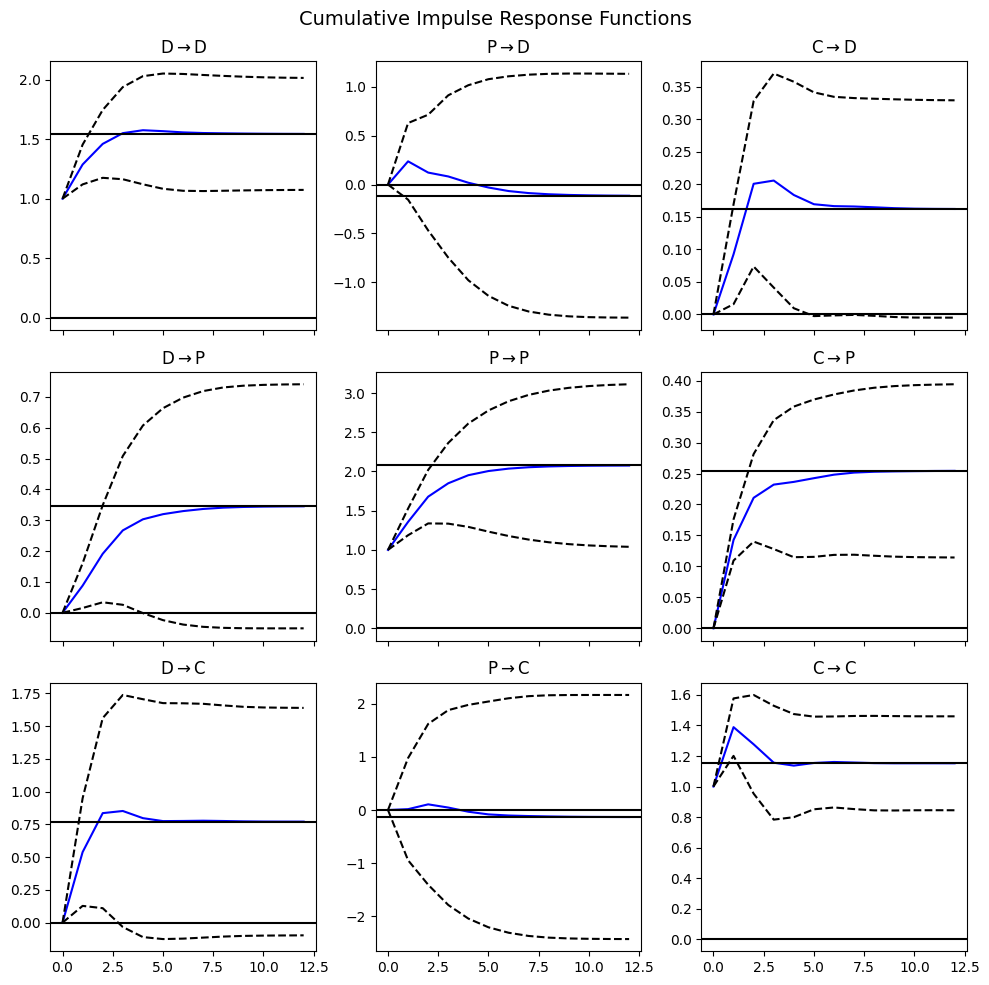

✓ IRF plots generated
  Note: Non-orthogonalized IRFs allow for correlated shocks
  Economic interpretation depends on contemporaneous correlations

----------------------------------------
STABILITY ANALYSIS
----------------------------------------
Eigenvalues of VAR(1) rep
0.4736889285433879
0.4736889285433879
0.5556113593576595
0.4421493838329046
0.04273435642456714
0.31949585297236804

STABILITY CONCLUSION:
✓ SYSTEM IS STABLE
  Evidence:
  - All eigenvalues inside unit circle
  - System returns to equilibrium after shocks
  - IRF plots should show convergence to zero
  ✓ Safe to proceed with scenario generation and optimization

----------------------------------------
SIMULATION VALIDATION
----------------------------------------
Generating 5000 simulations over 24 periods...
✓ Simulation completed. Shape: (5000, 24, 3)

Historical vs Simulated Correlations:
Historical correlation matrix:
          D         P         C
D  1.000000  0.452025  0.528024
P  0.452025  1.000000  0.5037

In [5]:
var_model = TwoStageCapacityAndProcurementPlanning.fit_VAR_model(
    data=data_subset,
    p=2,  # Let the function select optimal lag order
    # NOTE: Testing options can be adjusted as needed, the objective is to ensure model follows real economy dynamics
    testing=['stability', 'irf', 'corr', 'sim_stats', 'residual_tests'],
    method='bic',
    print_warnings=True
)

SHOCK DISTRIBUTION ANALYSIS

D Variable Analysis:
------------------------------
Mean: -0.000000 (should be ≈ 0)
Std:  0.0343
Skew: -0.146 (normal = 0)
Kurt: 1.207 (normal = 3)

Normality Tests:
Jarque-Bera p-value: 0.0061
Shapiro-Wilk p-value: 0.0439

Recommendation: t
Parameters: {'df': 6}
Reason: Non-normal but unclear pattern - conservative t-distribution

P Variable Analysis:
------------------------------
Mean: -0.000000 (should be ≈ 0)
Std:  0.0149
Skew: 0.429 (normal = 0)
Kurt: 2.465 (normal = 3)

Normality Tests:
Jarque-Bera p-value: 0.0000
Shapiro-Wilk p-value: 0.0001

Recommendation: t
Parameters: {'df': 6}
Reason: Non-normal but unclear pattern - conservative t-distribution

C Variable Analysis:
------------------------------
Mean: -0.000000 (should be ≈ 0)
Std:  0.0842
Skew: -0.371 (normal = 0)
Kurt: 3.267 (normal = 3)

Normality Tests:
Jarque-Bera p-value: 0.0000
Shapiro-Wilk p-value: 0.0000

Recommendation: t
Parameters: {'df': 10}
Reason: Non-normal but unclear pattern 

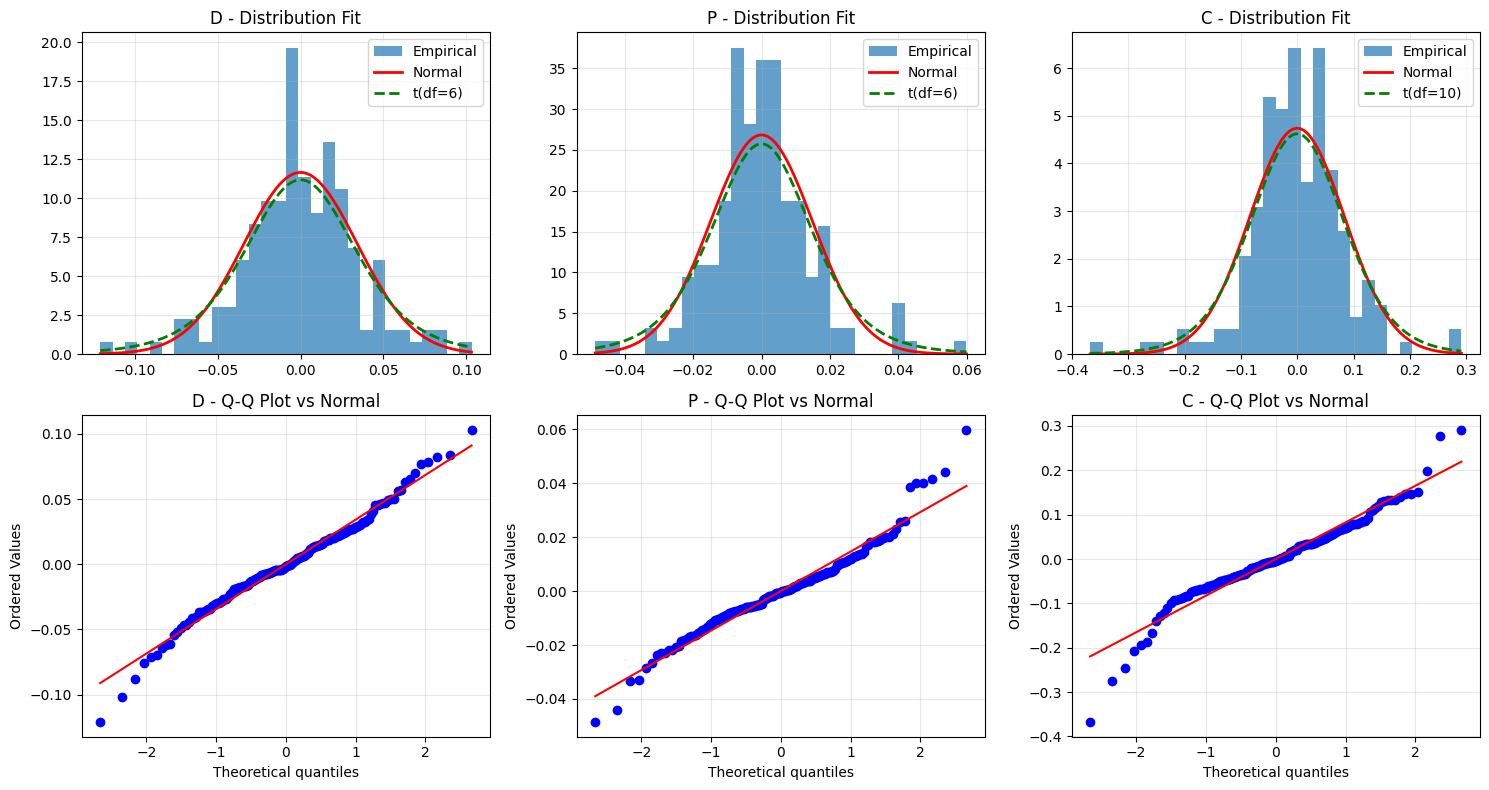

In [6]:
shock_distribution_analysis_results = TwoStageCapacityAndProcurementPlanning.analyze_shock_distributions(var_model)

In [7]:
scenario_returns, prob = TwoStageCapacityAndProcurementPlanning.generate_future_returns_scenarios(
    var_model=var_model, 
    simulation_start_date=data_subset.index.max().strftime('%Y-%m'),
    horizon=24,
    n_scenarios=1000,
    seed=42,
    shock_distribution='t',
    distribution_params={'df':7})

Setting up t distribution for shocks...
  Using multivariate t-distribution with df=7
    Tail behavior: Moderate tails

Generating VAR scenarios...
  Horizon: 24 periods
  Number of scenarios: 1000
  VAR lag order: 2
  Variables: ['D', 'P', 'C'] (assumed order)
  Shock distribution: t
  Initial conditions shape: (2, 3)
• Simulating scenarios...
  Progress: 10% (100/1000)
  Progress: 20% (200/1000)
  Progress: 30% (300/1000)
  Progress: 40% (400/1000)
  Progress: 50% (500/1000)
  Progress: 60% (600/1000)
  Progress: 70% (700/1000)
  Progress: 80% (800/1000)
  Progress: 90% (900/1000)
  Progress: 100% (1000/1000)
✓ Scenario simulation completed
• Formatting output DataFrame...
• Creating scenario probabilities...
• Validating generated scenarios...

SCENARIO GENERATION SUMMARY
Generated scenarios: 1000
Time horizon: 24 periods
Date range: 2020-01 to 2021-12
Output shape: (24000, 5)
Shock distribution: t
Distribution parameters: {'df': 7}

Scenario probabilities:
  Each scenario probabil

In [8]:
real_prices = {
    'P': 800,    # €/ton steel price
    'C': 400,    # €/ton scrap cost  
    'D': 50_000   # tons/month demand
}
scenario_levels, info = TwoStageCapacityAndProcurementPlanning.reconstruct_levels_from_returns(
    scenario_returns=scenario_returns,
    historical_data=data_subset,
    anchor_date=None,
    real_prices=real_prices
)

print(f"Steel prices range: €{scenario_levels['P'].min():.0f} - €{scenario_levels['P'].max():.0f}/ton")
print(f"Demand range: {scenario_levels['D'].min():,.0f} - {scenario_levels['D'].max():,.0f} tons/month")

LEVEL RECONSTRUCTION FROM RETURNS
Input validation completed:
  Scenarios: 1000
  Time periods: 24
  Total rows: 24000
  Date range: 2020-01 to 2021-12
Using last historical date as anchor: 2019-12-01

Initial levels from 2019-12-01:
  D: 100.2263
  P: 186.2000
  C: 381.2000

Setting up real price conversion...
  D: 100.2263 (index) -> 50000.00 (tons/month) [factor: 498.8711]
  P: 186.2000 (index) -> 800.00 (€/ton) [factor: 4.2965]
  C: 381.2000 (index) -> 400.00 (€/ton) [factor: 1.0493]

Reconstructing levels...
  Processing variable D...
    Applied conversion factor: 498.8711
    Level statistics - Min: 16400.56, Max: 195505.54, Mean: 54018.69
  Processing variable P...
    Applied conversion factor: 4.2965
    Level statistics - Min: 354.53, Max: 1983.29, Mean: 827.42
  Processing variable C...
    Applied conversion factor: 1.0493
    Level statistics - Min: 43.39, Max: 5003.48, Mean: 471.49

Final validation...
  ✓ No missing values in final output

RECONSTRUCTION SUMMARY
Success

SCENARIO EVOLUTION VISUALIZATION
Input validation completed:
  Total scenarios available: 1000
  Scenarios to display: 50
  Historical months to show: 180

Selecting 50 representative scenarios...
  Selected 25 high-probability scenarios
  Selected 25 representative scenarios
  Total probability coverage: 5.0%

Date ranges:
  Historical: 2005-01 to 2019-12 (180 months)
  Scenarios: 2020-01 to 2021-12 (24 months)

Detected scenarios in real units - converting historical data for consistency
Using anchor date: 2019-12-01 (last historical observation)
  D: index 100.23 -> real 51588 [factor: 514.7193]
  P: index 186.20 -> real 807 [factor: 4.3342]
  C: index 381.20 -> real 427 [factor: 1.1205]

Processing future trajectory for backtesting...
  Future trajectory: 24 months

Computing probability-weighted line thickness...
  Probability range: 0.0010 to 0.0010
  Line width: 1.0 (equal probabilities)

Generating plots...
  Processing D variable...
    Plotted 50 scenario trajectories
  Proce

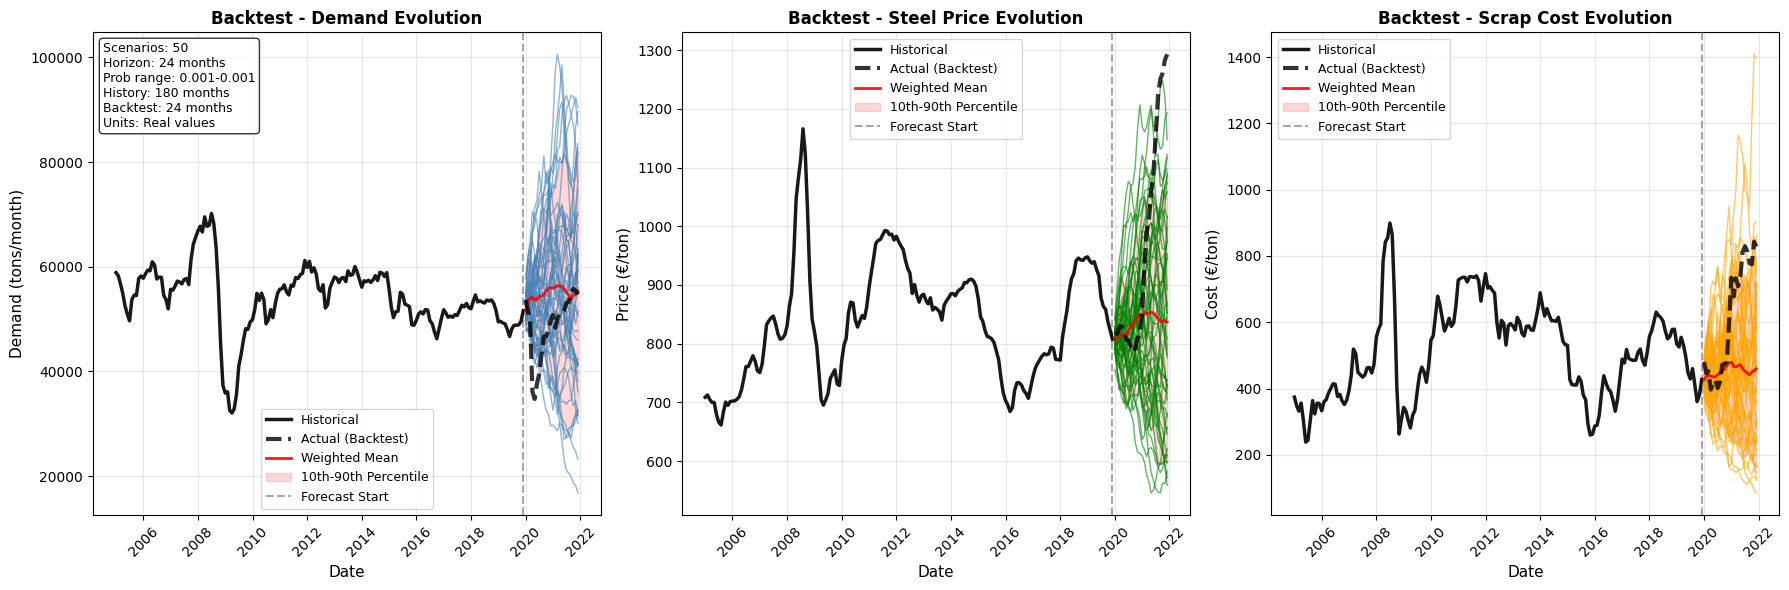

In [9]:
# Backtesting with actual trajectory
actual_future = data.loc['2020-01-01':'2021-12-01']
fig, axes = TwoStageCapacityAndProcurementPlanning.plot_scenarios_evolution(
    scenarios=scenario_levels,
    historical_data=data_subset,
    max_history=180,
    max_number_of_scenarios=50,
    prob=prob,
    future_trajectory=actual_future,
    title_prefix="Backtest - "
)

In [10]:
# With stress scenarios and diagnostics
scenarios_red, prob_red = TwoStageCapacityAndProcurementPlanning.reduce_scenarios_kmedoids(
    scenarios=scenario_levels,
    prob=prob,
    n_scenario_clusters=100,
    stress_pct=0.01
)

SCENARIO REDUCTION VIA K-MEDOIDS CLUSTERING
Input validation completed:
  Original scenarios: 1000
  Target scenarios: 100
  Stress percentage: 1.0%
  Reduction ratio: 10.0%

Building feature matrix for clustering...
  Feature matrix shape: (1000, 72)
  Features per scenario: 72 (3 variables × 24 time periods)

Standardizing features...
  Standardization completed
  Feature means: [ 0. -0. -0. -0.  0.]... (showing first 5)
  Feature stds:  [1. 1. 1. 1. 1.]... (showing first 5)

Identifying stress scenarios...
  Stress scenarios: 1 (1.0% of 100)
  Regular scenarios: 99
  Stress scenarios identified: ['s549']
  Stress scenario distances: [46.314]

Performing K-Medoids clustering...
  Data points to cluster: 999
  Target clusters: 99
  ✓ Clustering completed successfully
  Medoid scenarios: ['s75', 's548', 's757', 's485', 's970', 's695', 's990', 's141', 's196', 's367']...
  Cluster sizes: min=1, max=30, mean=10.1

Combining selected scenarios...
  Regular scenario medoids: 99
  Stress sce

SCENARIO EVOLUTION VISUALIZATION
Input validation completed:
  Total scenarios available: 100
  Scenarios to display: 50
  Historical months to show: 180

Selecting 50 representative scenarios...
  Selected 25 high-probability scenarios
  Selected 25 representative scenarios
  Total probability coverage: 72.5%

Date ranges:
  Historical: 2005-01 to 2019-12 (180 months)
  Scenarios: 2020-01 to 2021-12 (24 months)

Detected scenarios in real units - converting historical data for consistency
Using anchor date: 2019-12-01 (last historical observation)
  D: index 100.23 -> real 51131 [factor: 510.1566]
  P: index 186.20 -> real 806 [factor: 4.3266]
  C: index 381.20 -> real 427 [factor: 1.1189]

Processing future trajectory for backtesting...
  Future trajectory: 24 months

Computing probability-weighted line thickness...
  Probability range: 0.0010 to 0.0297
  Line width range: 0.3 to 2.5

Generating plots...
  Processing D variable...
    Plotted 50 scenario trajectories
  Processing P v

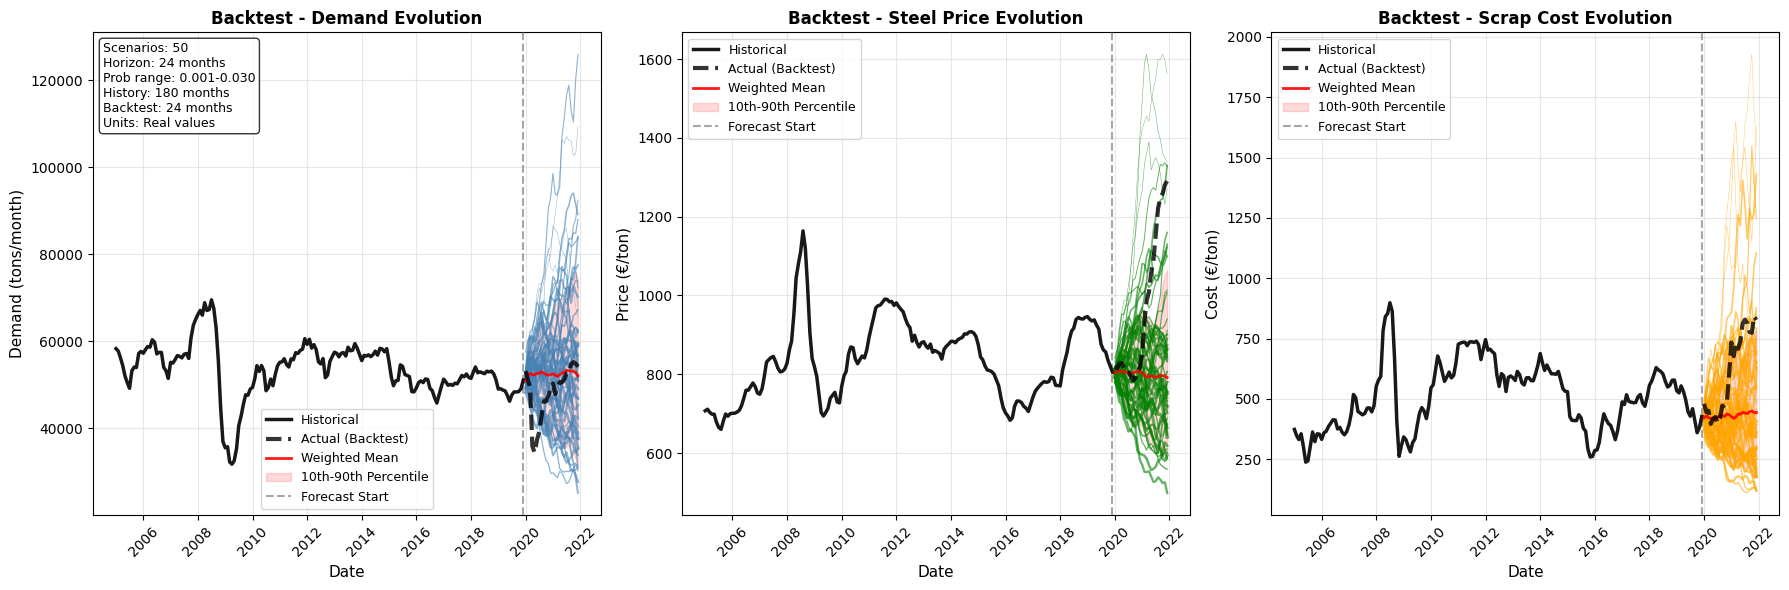

In [11]:
fig, axes = TwoStageCapacityAndProcurementPlanning.plot_scenarios_evolution(
    scenarios=scenarios_red,
    historical_data=data_subset,
    max_history=180,
    max_number_of_scenarios=50,
    prob=prob_red,
    future_trajectory=actual_future,
    title_prefix="Backtest - "
)

In [12]:
decisions = TwoStageCapacityAndProcurementPlanning.optimize_capacity_and_procurement(
    scenarios=scenarios_red,
    prob=prob_red,
    alpha=1.01,  # scrap-to-product ratio
    c_var=250.0, # variable production cost €/ton
    c_cap_base=10.0, # fixed capacity cost €/ton capacity
    c_cap_flex=30.0, # flexible capacity cost €/ton capacity
    delta_base=5.0, # base scrap procurement premium €/ton
    delta_spot=15.0, # spot scrap procurement premium €/ton
    pen_unmet=10.0, # penalty cost for unmet demand €/ton
    gamma_cap=0.3, # capacity adjustment cost factor
    gamma_scrap=0.8, # scrap procurement adjustment cost factor
    solver="highs"
)

print("Optimal capacity decisions:")
decisions

TWO-STAGE STOCHASTIC PROGRAMMING OPTIMIZATION
Validating inputs...
✓ Input validation completed
  Time periods: 24
  Scenarios: 100
  Total probability: 1.000000
Building parameter dictionaries...
✓ Parameter dictionaries built
  Average demand: 61056.2
  Average price: €915.1/ton
  Average cost: €646.2/ton
Building optimization model...
  Sets defined: T=24, S=100
  Variables defined: 14424 total
Adding constraints...
✓ Constraints added:
  Demand balance: 2400 constraints
  Capacity and operational: 12000 constraints
  Recourse bounds: 4800 constraints
Building objective function...
✓ Objective function built (maximize expected profit)

Solving with highs solver...
✓ Optimization completed successfully
  Termination condition: optimal
  Solution status: ok
  Optimal objective value: €128,191,283
Extracting optimal decisions...
✓ Results extracted successfully
  Decision variables: (24, 2)
  Date range: 2020-01-01 00:00:00 to 2021-12-01 00:00:00

OPTIMIZATION SUMMARY
Model statistics:

,Cap_base,Q_base
Date,,
2020-01-01,51526.553504,52041.819040
2020-02-01,53528.193400,54063.475334
2020-03-01,53592.631854,54128.558173
2020-04-01,54591.446290,55137.360753
2020-05-01,53916.700194,54455.867196
2020-06-01,53665.164918,54201.816567
2020-07-01,53657.494327,54194.069270
2020-08-01,54331.646999,54874.963469
2020-09-01,55073.802848,55450.633454


PROFIT DISTRIBUTION ANALYSIS OVER TIME
Validating inputs...
✓ Input validation completed
  Time periods: 24
  Scenarios: 100
  Date range: 2020-01 to 2021-12

Calculating profits for all scenario-period combinations...


  Progress: 5.0% (120/2400)
  Progress: 10.0% (240/2400)
  Progress: 15.0% (360/2400)
  Progress: 20.0% (480/2400)
  Progress: 25.0% (600/2400)
  Progress: 30.0% (720/2400)
  Progress: 35.0% (840/2400)
  Progress: 40.0% (960/2400)
  Progress: 45.0% (1080/2400)
  Progress: 50.0% (1200/2400)
  Progress: 55.0% (1320/2400)
  Progress: 60.0% (1440/2400)
  Progress: 65.0% (1560/2400)
  Progress: 70.0% (1680/2400)
  Progress: 75.0% (1800/2400)
  Progress: 80.0% (1920/2400)
  Progress: 85.0% (2040/2400)
  Progress: 90.0% (2160/2400)
  Progress: 95.0% (2280/2400)
  Progress: 100.0% (2400/2400)
✓ Profit calculations completed: 2400 results

Processing profit results...
  Profit matrix shape: (24, 100)
  Probability alignment: 100 scenarios
Computing monthly statistics...
✓ Monthly statistics computed for 24 periods
Computing cumulative profit analysis...
✓ Cumulative analysis completed
  Expected cumulative profit: €128,191,283
  Cumulative profit std: €76,307,525

Generating visualizations...


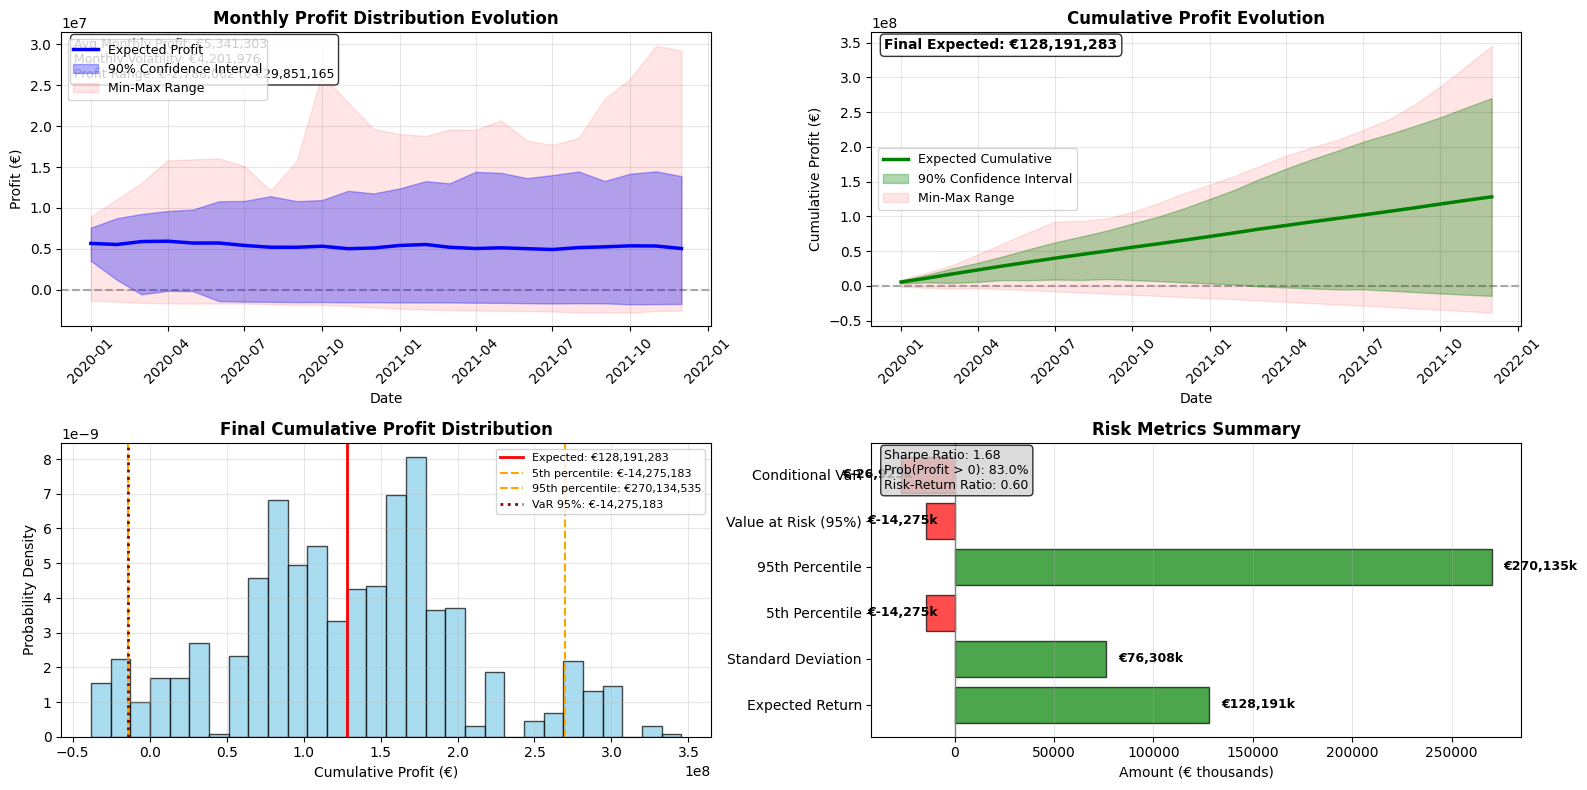


PROFIT DISTRIBUTION ANALYSIS SUMMARY
Analysis period: 2020-01 to 2021-12
Number of scenarios: 100
Confidence interval: 90%

Monthly Profit Statistics:
  Average expected monthly profit: €5,341,303
  Monthly profit volatility (avg std): €4,201,976
  Best month (expected): 2020-04 (€5,941,540)
  Worst month (expected): 2021-07 (€4,920,529)

Cumulative Profit Statistics:
  Expected cumulative profit: €128,191,283
  Cumulative profit standard deviation: €76,307,525
  5th percentile: €-14,275,183
  95th percentile: €270,134,535
  Value at Risk (95%): €-14,275,183
  Conditional Value at Risk: €-26,925,240

Risk Assessment:
  Probability of overall loss: 17.0%
  Probability of exceeding 110% of expected profit: 36.0%
  Risk-adjusted return (Sharpe-like ratio): 1.680
  ✓ Strong risk-adjusted returns

✓ Profit distribution analysis completed successfully
  Returns: Dictionary with monthly_profits, monthly_stats, cumulative_profits, etc.
Expected total profit: €128,191,283


In [14]:
import warnings
import pandas as pd

# Suppress specific pandas warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings('ignore', message='.*DataFrame.stack.*')

# After optimization
profit_analysis = TwoStageCapacityAndProcurementPlanning.plot_profit_distribution_over_time(
    decisions=decisions,
    scenarios=scenarios_red,
    prob=prob_red,
    alpha=1.01,  # scrap-to-product ratio
    c_var=250.0, # variable production cost €/ton
    c_cap_base=10.0, # fixed capacity cost €/ton capacity
    c_cap_flex=30.0, # flexible capacity cost €/ton capacity
    delta_base=5.0, # base scrap procurement premium €/ton
    delta_spot=15.0, # spot scrap procurement premium €/ton
    pen_unmet=10.0, # penalty cost for unmet demand €/ton
    gamma_cap=0.3, # capacity adjustment cost factor
    gamma_scrap=0.8, # scrap procurement adjustment cost factor
    confidence_levels=[0.05, 0.95],  # 90% CI
)

print(f"Expected total profit: €{profit_analysis['cumulative_stats']['expected_cumulative']:,.0f}")

BACKTESTING SIMULATION
Validating inputs...
✓ Input validation completed
  Simulation period: 2020-01-01 00:00:00 to 2021-12-01 00:00:00
  Number of periods: 24

Converting actual data to real units...
  D: index 104.28 -> real 50000 [factor: 479.4875]
  P: index 189.00 -> real 800 [factor: 4.2328]
  C: index 428.50 -> real 400 [factor: 0.9335]

Running monthly simulations...
  Simulating 2020-01... Profit: €6,524,525
  Simulating 2020-02... Profit: €7,474,829
  Simulating 2020-03... Profit: €7,527,740
  Simulating 2020-04... Profit: €6,820,487
  Simulating 2020-05... Profit: €5,596,983
  Simulating 2020-06... Profit: €5,490,123
  Simulating 2020-07... Profit: €6,559,961
  Simulating 2020-08... Profit: €6,166,210
  Simulating 2020-09... Profit: €4,400,907
  Simulating 2020-10... Profit: €4,656,670
  Simulating 2020-11... Profit: €5,247,432
  Simulating 2020-12... Profit: €1,212,189
  Simulating 2021-01... Profit: €-1,314,698
  Simulating 2021-02... Profit: €3,396,947
  Simulating 2021-

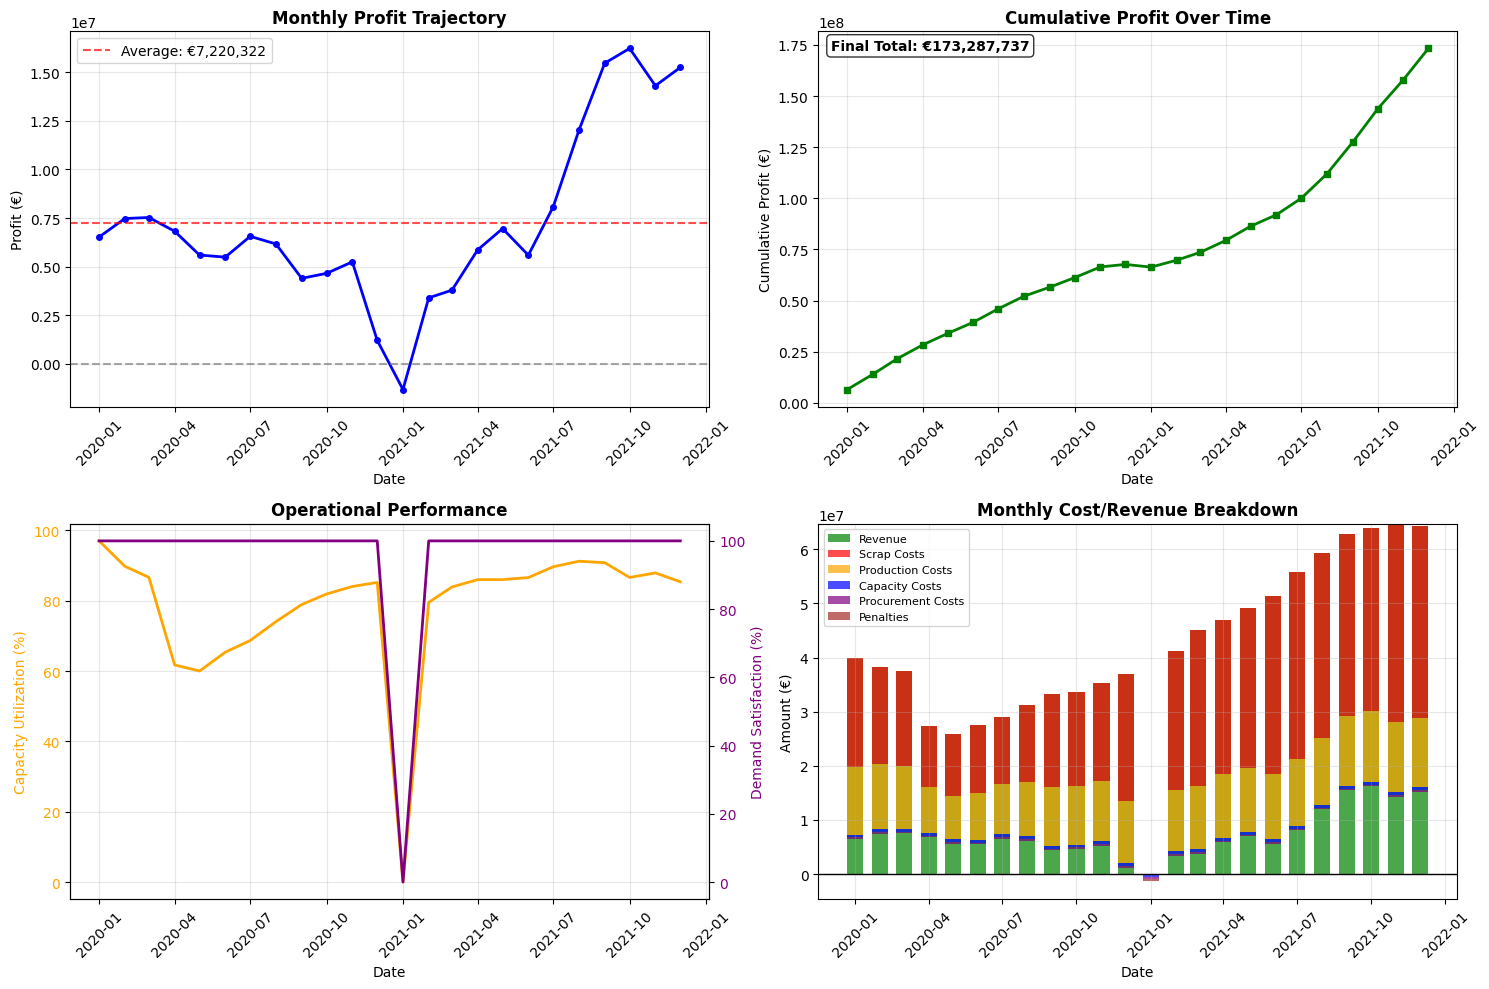


BACKTESTING SUMMARY
Simulation period: 2020-01 to 2021-12
Number of periods: 24

Financial Performance:
  Total profit: €173,287,737
  Average monthly profit: €7,220,322
  Profit volatility (std): €4,439,818
  Best month: 2021-10 (€16,220,874)
  Worst month: 2021-01 (€-1,314,698)

Operational Performance:
  Average capacity utilization: 78.6%
  Average demand satisfaction: 95.8%
  Total unmet demand: 47,294 tons/month
  Flexible capacity used: 0.0% of months
  Spot procurement used: 8.3% of months

Cost Analysis:
  Total revenue: €1,001,071,646
  Total costs: €827,783,909
  Profit margin: 17.3%

✓ Backtesting simulation completed successfully
  Returns: Dictionary with monthly_profits, cumulative_profits, operational_metrics, summary_stats, cost_breakdown
Total profit: €173,287,737


In [15]:
# Run backtesting simulation
actual_future = data.loc['2020-01-01':'2021-12-01']
backtest_results = TwoStageCapacityAndProcurementPlanning.backtesting_simulation(
    decisions=decisions,
    actual_future_data=actual_future,
    alpha=1.01,  # scrap-to-product ratio
    c_var=250.0, # variable production cost €/ton
    c_cap_base=10.0, # fixed capacity cost €/ton capacity
    c_cap_flex=30.0, # flexible capacity cost €/ton capacity
    delta_base=5.0, # base scrap procurement premium €/ton
    delta_spot=15.0, # spot scrap procurement premium €/ton
    pen_unmet=10.0, # penalty cost for unmet demand €/ton
    gamma_cap=0.3, # capacity adjustment cost factor
    gamma_scrap=0.8, # scrap procurement adjustment cost factor
    real_prices={'P': 800, 'C': 400, 'D': 50000}
)

print(f"Total profit: €{backtest_results['summary_stats']['total_profit']:,.0f}")